In [2]:
import pysam
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [45]:
ssr = pysam.AlignmentFile("data/SRR_final_sorted.bam", "rb")

In [182]:
def bin_and_smooth(coverage, bin_size, smoothing_sigma):
    bases_summed = np.array(coverage).sum(axis=0)
    bins = np.split(bases_summed, range(bin_size, len(bases_summed), bin_size))
    bins = bins[:-1] if len(bins[-1]) != bin_size else bins # drop last bin if not full
    weighted_hist = np.array([el.sum() for el in bins])
    smoothed = ndimage.gaussian_filter1d(weighted_hist, smoothing_sigma)
    return smoothed
    
def find_cutoff(signal):
    nonzero = signal[np.where(signal != 0)] # filter zeros due to bad reads - centromere
    log_signal = np.log(nonzero)
    mean_log_signal = np.mean(log_signal)
    std_log_signal = np.std(log_signal)
    return np.exp(mean_log_signal - std_log_signal), np.exp(mean_log_signal + std_log_signal)

def merge(signal, loc, bin_size):
    ends, = np.where(loc[1:] - loc[:-1]!=1) 
    loc_merged = np.split(loc, ends)
    return [(l[0]*bin_size+1, l[-1]*bin_size, np.mean(signal[l])) for l in loc_merged]

def convert(signal, low, high, bin_size):
    print(f"DEL bins: {np.sum(signal < low)}, DUP bins: {np.sum(signal > high)}")
    loc_low, = np.where(signal < low)
    loc_high, = np.where(signal > high)
    deletions = merge(signal, loc_low, bin_size)
    insertions = merge(signal, loc_high, bin_size)
    print(f"DEL regions:{len(deletions)}, DUP regions:{len(insertions)}")
    return deletions, insertions


def plot_signal_with_cutoff(signal, low, high):
    plt.plot(signal)
    plt.plot([0, len(signal)], [low] * 2)
    plt.plot([0, len(signal)], [high] * 2)
    plt.legend(["signal", "low", "high"])

In [188]:
def process_chr(chr, data, vcf, plot=False):
    print("Processing ", chr)
    signal = bin_and_smooth(data.count_coverage(chr, 0, 250_000_000), 1_000, 100)
    low, high = find_cutoff(signal)
    if plot:
        plot_signal_with_cutoff(signal, low, high)
        plt.title(chr)
    res = convert(signal, low, high, 1_000)
    if vcf:
        for content, sv_type in zip(res, ["DEL", "DUP"]):
            for i, (start, end, mean_signal) in enumerate(content):
                rec = vcf.new_record()
                rec.chrom = chr
                rec.pos = start
                rec.stop = end
                rec.id = f"cgp4_{chr}_{sv_type}_{i}"
                rec.alts = [f"<{sv_type}>"]
                rec.filter.add("PASS")
                
                rec.info["meanSignal"] = round(mean_signal, 10)
                rec.info["lowCut"] = round(low, 5)
                rec.info["highCut"] = round(high, 5)
                vcf.write(rec)

In [181]:
import datetime 
h = pysam.VariantFile("template.vcf")
h.header.add_line(f"##fileDate={datetime.date.today().isoformat()}")

DEL bins: 64431, INS bins: 37884
DEL regions:80, INS regions:92


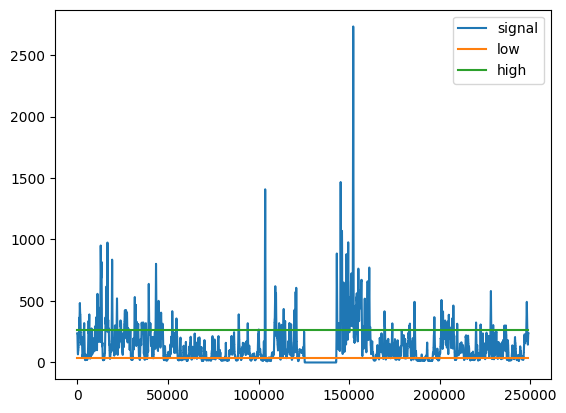

In [180]:
test = pysam.VariantFile("test.vcf", "w", header=h.header)
chr1 = process_chr("chr1", ssr, test, True)
test.close()

In [185]:
def process_all(data_path, output_path, template_path="template.vcf"):
    import datetime 
    template = pysam.VariantFile(template_path)
    template.header.add_line(f"##fileDate={datetime.date.today().isoformat()}")
    
    data = pysam.AlignmentFile(data_path, "rb")
    output = pysam.VariantFile(output_path, "w", header=template.header)
    chrs = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    for chr in chrs:
        process_chr(chr, data, output)
    output.close()

In [186]:
process_all("data/SRR_final_sorted.bam", "output/cgp4.vcf")

Processing  chr1
DEL bins: 64431, DUP bins: 37884
DEL regions:80, DUP regions:92
Processing  chr2
DEL bins: 55763, DUP bins: 44331
DEL regions:93, DUP regions:113
Processing  chr3
DEL bins: 40437, DUP bins: 37886
DEL regions:83, DUP regions:86
Processing  chr4
DEL bins: 38661, DUP bins: 38074
DEL regions:88, DUP regions:104
Processing  chr5
DEL bins: 35468, DUP bins: 34411
DEL regions:73, DUP regions:79
Processing  chr6
DEL bins: 34704, DUP bins: 31085
DEL regions:61, DUP regions:78
Processing  chr7
DEL bins: 31938, DUP bins: 29654
DEL regions:73, DUP regions:67
Processing  chr8
DEL bins: 28026, DUP bins: 27387
DEL regions:65, DUP regions:63
Processing  chr9
DEL bins: 41908, DUP bins: 21981
DEL regions:44, DUP regions:54
Processing  chr10
DEL bins: 29862, DUP bins: 25104
DEL regions:51, DUP regions:65
Processing  chr11
DEL bins: 31932, DUP bins: 23902
DEL regions:41, DUP regions:49
Processing  chr12
DEL bins: 26528, DUP bins: 23579
DEL regions:57, DUP regions:45
Processing  chr13
DEL b

Processing  chr1
DEL bins: 64431, DUP bins: 37884
DEL regions:80, DUP regions:92


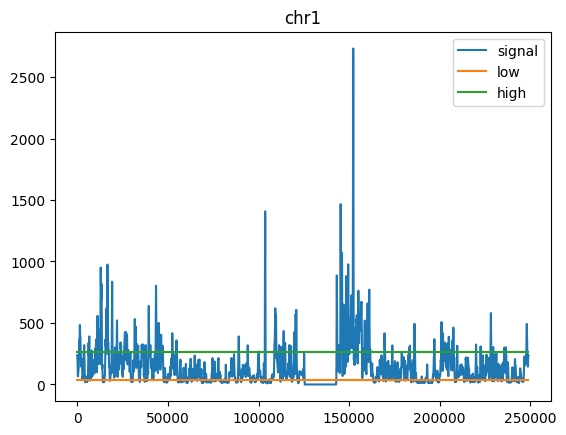

Processing  chr2
DEL bins: 55763, DUP bins: 44331
DEL regions:93, DUP regions:113


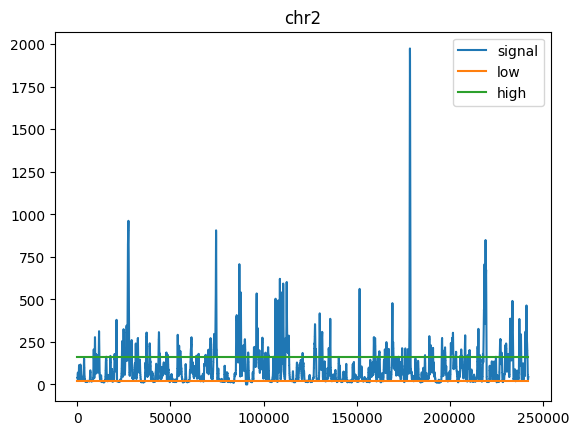

Processing  chr3
DEL bins: 40437, DUP bins: 37886
DEL regions:83, DUP regions:86


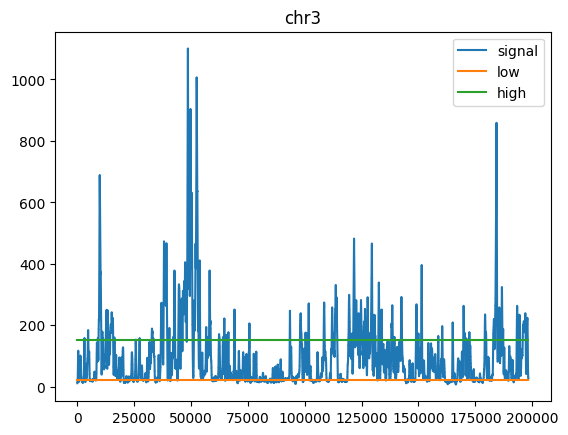

Processing  chr4
DEL bins: 38661, DUP bins: 38074
DEL regions:88, DUP regions:104


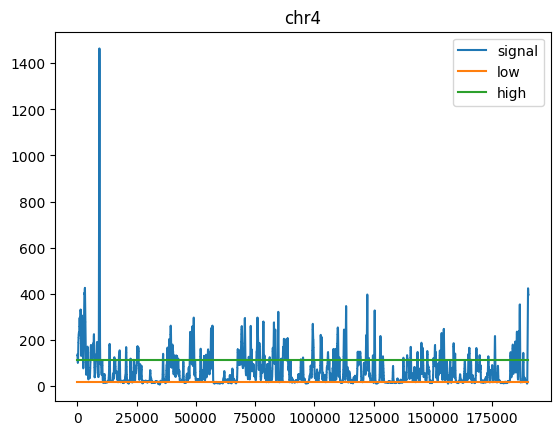

Processing  chr5
DEL bins: 35468, DUP bins: 34411
DEL regions:73, DUP regions:79


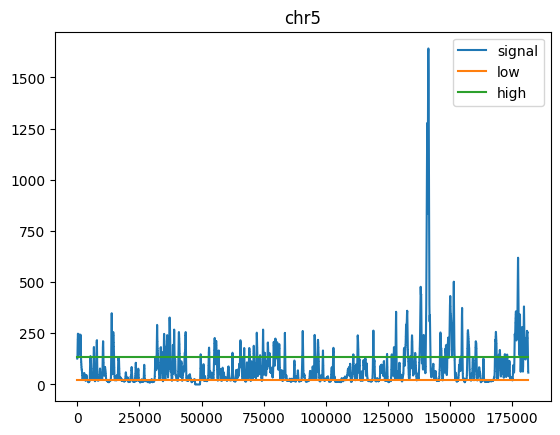

Processing  chr6
DEL bins: 34704, DUP bins: 31085
DEL regions:61, DUP regions:78


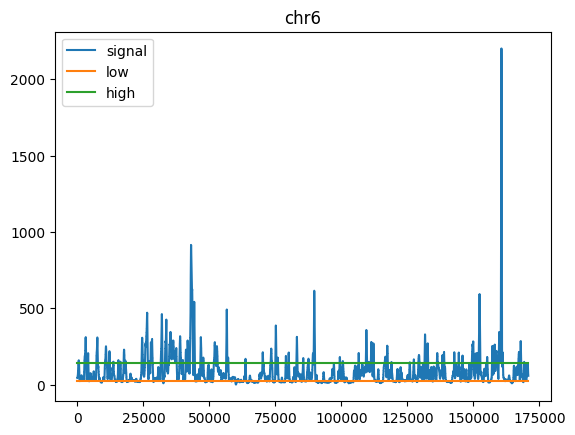

Processing  chr7
DEL bins: 31938, DUP bins: 29654
DEL regions:73, DUP regions:67


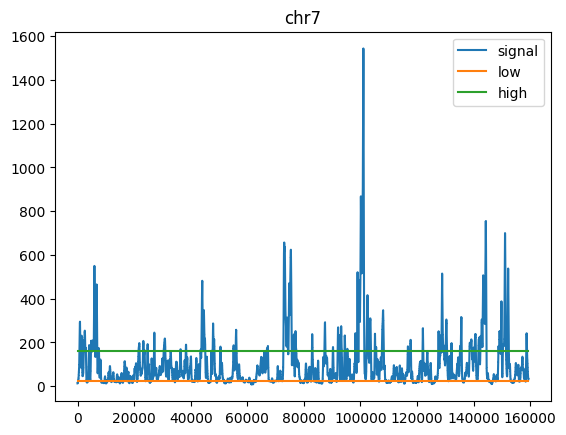

Processing  chr8
DEL bins: 28026, DUP bins: 27387
DEL regions:65, DUP regions:63


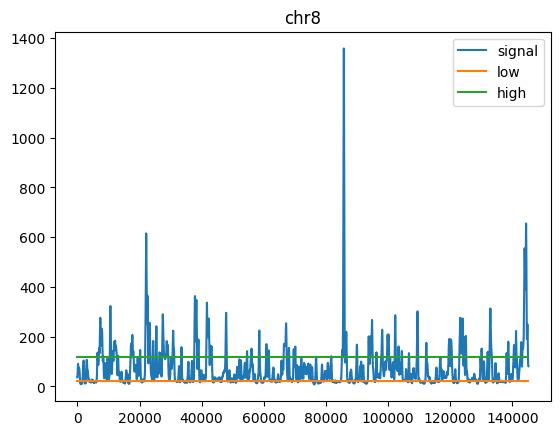

Processing  chr9
DEL bins: 41908, DUP bins: 21981
DEL regions:44, DUP regions:54


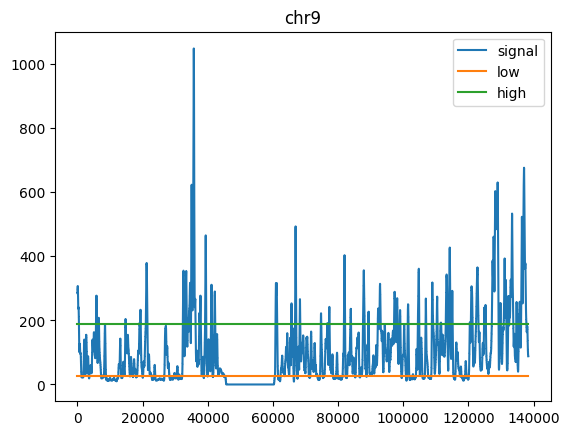

Processing  chr10
DEL bins: 29862, DUP bins: 25104
DEL regions:51, DUP regions:65


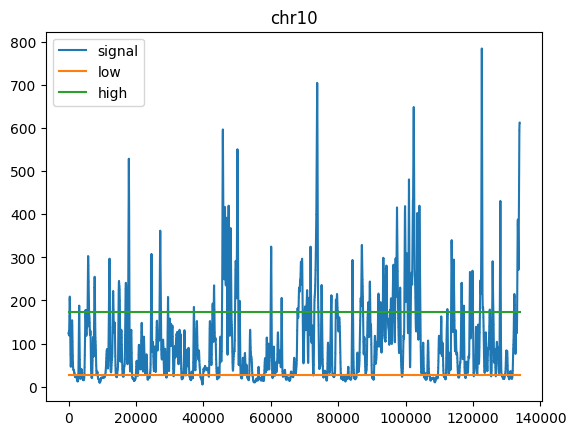

Processing  chr11
DEL bins: 31932, DUP bins: 23902
DEL regions:41, DUP regions:49


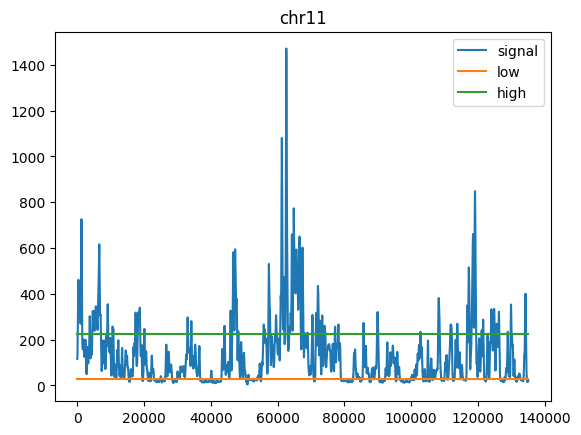

Processing  chr12
DEL bins: 26528, DUP bins: 23579
DEL regions:57, DUP regions:45


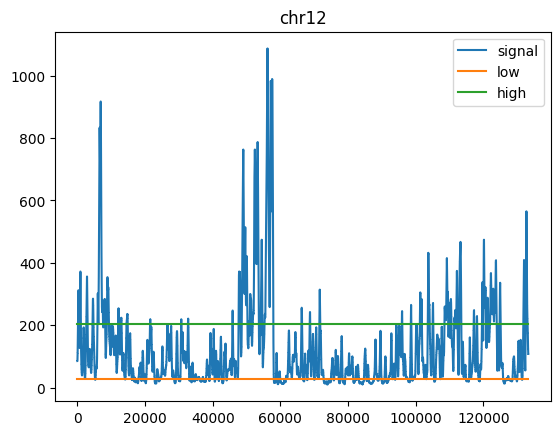

Processing  chr13
DEL bins: 37167, DUP bins: 19161
DEL regions:55, DUP regions:49


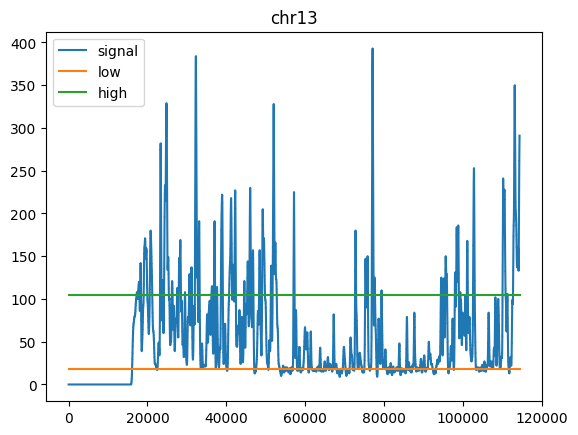

Processing  chr14
DEL bins: 36305, DUP bins: 15106
DEL regions:30, DUP regions:32


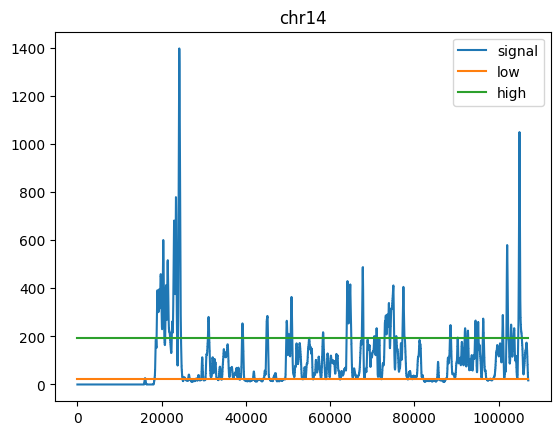

Processing  chr15
DEL bins: 33477, DUP bins: 14261
DEL regions:28, DUP regions:39


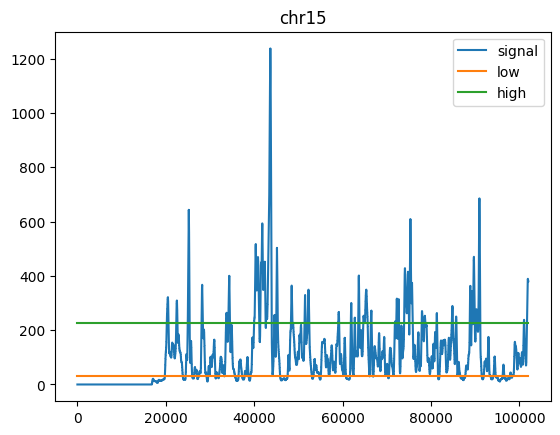

Processing  chr16
DEL bins: 27877, DUP bins: 17046
DEL regions:29, DUP regions:33


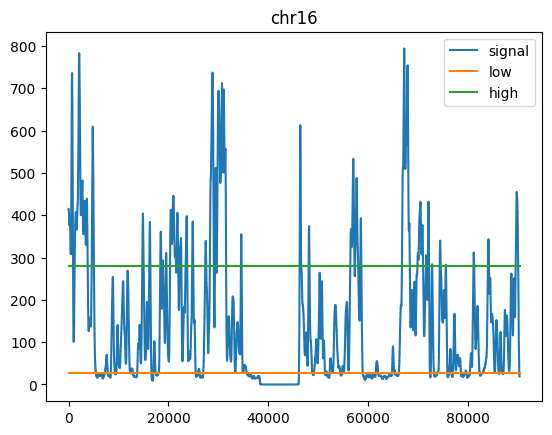

Processing  chr17
DEL bins: 16730, DUP bins: 13046
DEL regions:25, DUP regions:31


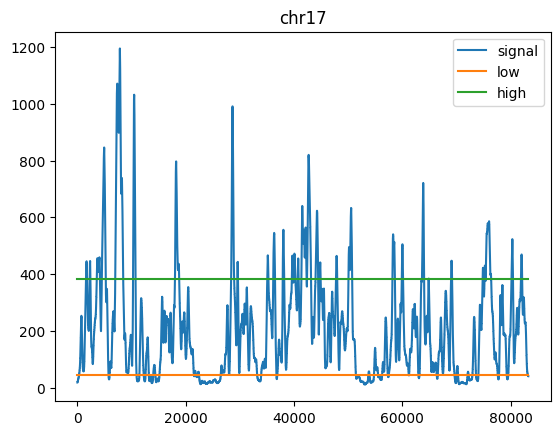

Processing  chr18
DEL bins: 15857, DUP bins: 16104
DEL regions:39, DUP regions:43


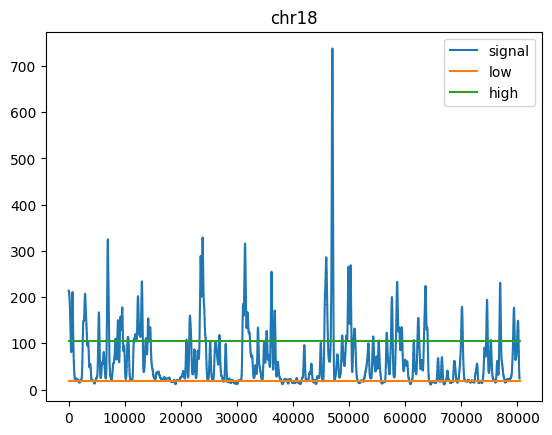

Processing  chr19
DEL bins: 11390, DUP bins: 3850
DEL regions:12, DUP regions:14


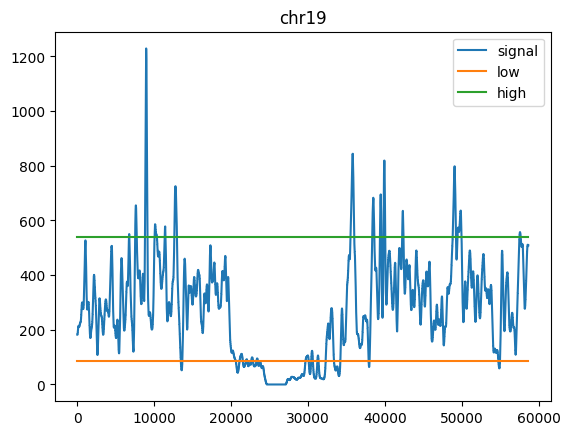

Processing  chr20
DEL bins: 14461, DUP bins: 12132
DEL regions:33, DUP regions:30


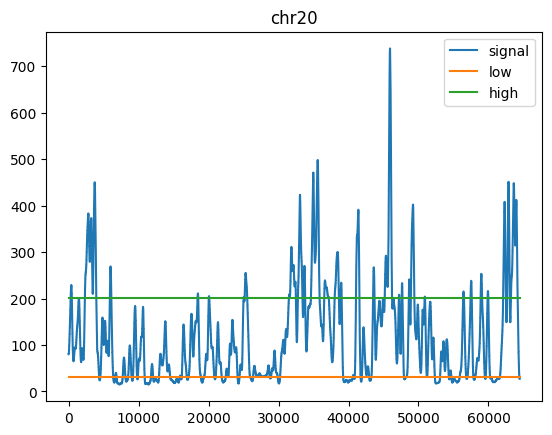

Processing  chr21
DEL bins: 13450, DUP bins: 7402
DEL regions:19, DUP regions:17


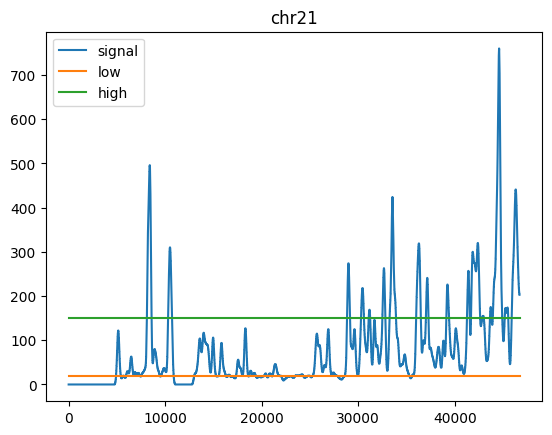

Processing  chr22
DEL bins: 19475, DUP bins: 4196
DEL regions:11, DUP regions:14


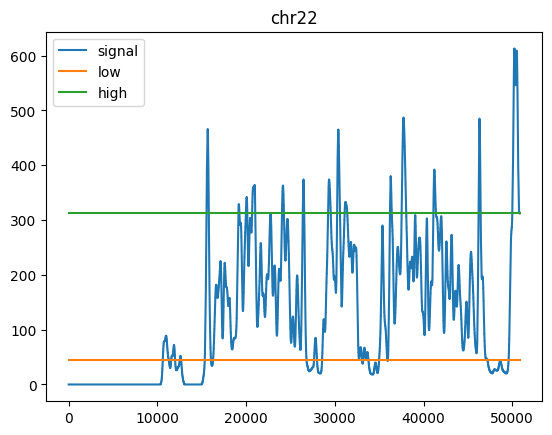

Processing  chrX
DEL bins: 31179, DUP bins: 28854
DEL regions:70, DUP regions:66


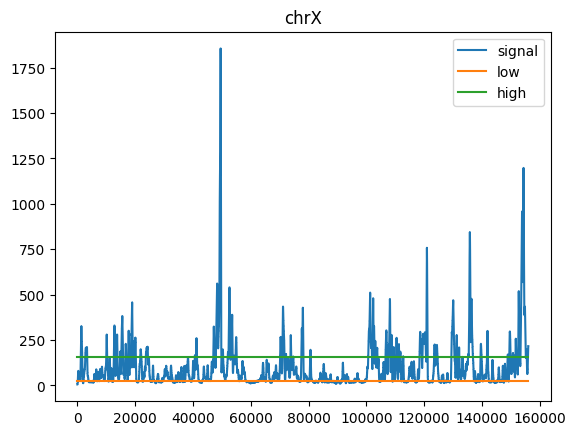

Processing  chrY
DEL bins: 49947, DUP bins: 1781
DEL regions:15, DUP regions:3


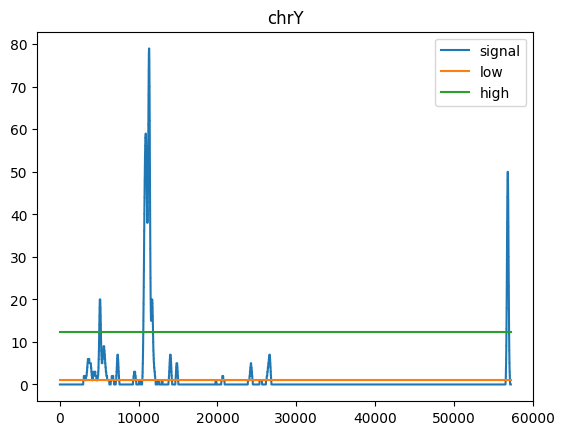

In [190]:
chrs = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
for chr in chrs:
    process_chr(chr, ssr, None, True)
    plt.show()